# tutorial 2: state space models
- https://pyro.ai/examples/forecasting_ii.html

In [1]:
import math
import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.contrib.examples.bart import load_bart_od
from pyro.contrib.forecast import ForecastingModel, Forecaster, eval_crps
from pyro.infer.reparam import LinearHMMReparam, StableReparam, SymmetricStableReparam
from pyro.ops.tensor_utils import periodic_repeat
from pyro.ops.stats import quantile
import matplotlib.pyplot as plt

pyro.enable_validation(True)
pyro.set_rng_seed(20200305)

In [2]:
dataset = load_bart_od()
print(dataset.keys())
print(dataset["counts"].shape)
print(" ".join(dataset["stations"]))

dict_keys(['stations', 'start_date', 'counts'])
torch.Size([78888, 50, 50])
12TH 16TH 19TH 24TH ANTC ASHB BALB BAYF BERY CAST CIVC COLM COLS CONC DALY DBRK DELN DUBL EMBR FRMT FTVL GLEN HAYW LAFY LAKE MCAR MLBR MLPT MONT NBRK NCON OAKL ORIN PCTR PHIL PITT PLZA POWL RICH ROCK SANL SBRN SFIA SHAY SSAN UCTY WARM WCRK WDUB WOAK


torch.Size([78888, 1])


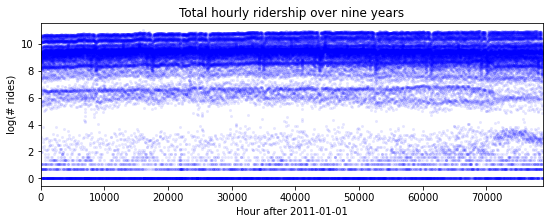

In [3]:
data = dataset["counts"].sum([-1, -2]).unsqueeze(-1).log1p()
print(data.shape)
plt.figure(figsize=(9, 3))
plt.plot(data, 'b.', alpha=0.1, markeredgewidth=0)
plt.title("Total hourly ridership over nine years")
plt.ylabel("log(# rides)")
plt.xlabel("Hour after 2011-01-01")
plt.xlim(0, len(data));

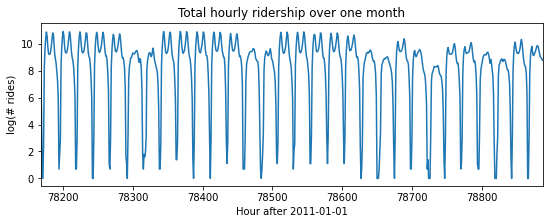

In [16]:
plt.figure(figsize=(9, 3))
plt.plot(data)
plt.title("Total hourly ridership over one month")
plt.ylabel("log(# rides)")
plt.xlabel("Hour after 2011-01-01")
plt.xlim(len(data) - 24 * 30, len(data));

In [17]:
T0 = 0                # beginning
T2 = data.size(-2)    # end
T1 = T2 - 24 * 7 * 2  # train/test split
means = data[:T1 // (24 * 7) * 24 * 7].reshape(-1, 24 * 7).mean(0)

In [56]:
class Model1(ForecastingModel):
    def model(self, zero_data, covariates):
        duration = zero_data.size(-2)

        # We'll hard-code the periodic part of this model, learning only the local model.
        prediction = periodic_repeat(means, duration, dim=-1).unsqueeze(-1)

        # On top of this mean prediction, we'll learn a linear dynamical system.
        # This requires specifying five pieces of data, on which we will put structured priors.
        init_dist = dist.Normal(0, 10).expand([1]).to_event(1)

        timescale = pyro.sample("timescale", dist.LogNormal(math.log(24), 1))
        # Note timescale is a scalar but we need a 1x1 transition matrix (hidden_dim=1),
        # thus we unsqueeze twice using [..., None, None].
        trans_matrix = torch.exp(-1 / timescale)[..., None, None]
        trans_scale = pyro.sample("trans_scale", dist.LogNormal(-0.5 * math.log(24), 1))
        trans_dist = dist.Normal(0, trans_scale.unsqueeze(-1)).to_event(1)

        # Note the obs_matrix has shape hidden_dim x obs_dim = 1 x 1.
        obs_matrix = torch.tensor([[1.]])
        obs_scale = pyro.sample("obs_scale", dist.LogNormal(-2, 1))
        obs_dist = dist.Normal(0, obs_scale.unsqueeze(-1)).to_event(1)

        noise_dist = dist.GaussianHMM(
            init_dist, trans_matrix, trans_dist, obs_matrix, obs_dist, duration=duration)
        self.predict(noise_dist, prediction)

In [57]:
pyro.set_rng_seed(1)
pyro.clear_param_store()
covariates = torch.zeros(len(data), 0)  # empty
forecaster = Forecaster(Model1(), data[:T1], covariates[:T1], learning_rate=0.1, num_steps=400)
for name, value in forecaster.guide.median().items():
    if value.numel() == 1:
        print("{} = {:0.4g}".format(name, value.item()))

INFO 	 step    0 loss = 0.878717
INFO 	 step  100 loss = 0.65062
INFO 	 step  200 loss = 0.650556
INFO 	 step  300 loss = 0.650474


timescale = 4.34
trans_scale = 0.4611
obs_scale = 0.02157


torch.Size([100, 336, 1]) torch.Size([336])


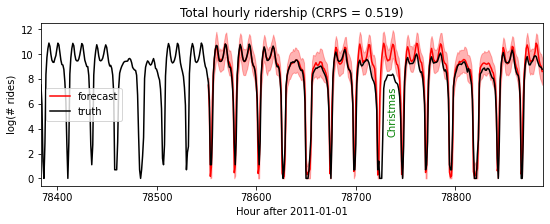

In [59]:
samples = forecaster(data[:T1], covariates, num_samples=100)
samples.clamp_(min=0)  # apply domain knowledge: the samples must be positive
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, data[T1:])
print(samples.shape, p10.shape)

plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(torch.arange(T1 - 24 * 7, T2),
         data[T1 - 24 * 7: T2], 'k-', label='truth')
plt.title("Total hourly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Hour after 2011-01-01")
plt.xlim(T1 - 24 * 7, T2)
plt.text(78732, 3.5, "Christmas", rotation=90, color="green")
plt.legend(loc="best");

In [60]:
class Model2(ForecastingModel):
    def model(self, zero_data, covariates):
        duration = zero_data.size(-2)
        prediction = periodic_repeat(means, duration, dim=-1).unsqueeze(-1)

        init_dist = dist.Normal(0, 10).expand([1]).to_event(1)
        timescale = pyro.sample("timescale", dist.LogNormal(math.log(24), 1))
        trans_matrix = torch.exp(-1 / timescale)[..., None, None]
        trans_scale = pyro.sample("trans_scale", dist.LogNormal(-0.5 * math.log(24), 1))
        trans_dist = dist.Normal(0, trans_scale.unsqueeze(-1)).to_event(1)
        obs_matrix = torch.tensor([[1.]])

        # To model heteroskedastic observation noise, we'll sample obs_scale inside a plate,
        # then repeat to full duration. This is the only change from Model1.
        with pyro.plate("hour_of_week", 24 * 7, dim=-1):
            obs_scale = pyro.sample("obs_scale", dist.LogNormal(-2, 1))
        obs_scale = periodic_repeat(obs_scale, duration, dim=-1)

        obs_dist = dist.Normal(0, obs_scale.unsqueeze(-1)).to_event(1)
        noise_dist = dist.GaussianHMM(
            init_dist, trans_matrix, trans_dist, obs_matrix, obs_dist, duration=duration)
        self.predict(noise_dist, prediction)

In [61]:
pyro.set_rng_seed(1)
pyro.clear_param_store()
covariates = torch.zeros(len(data), 0)  # empty
forecaster = Forecaster(Model2(), data[:T1], covariates[:T1], learning_rate=0.1, num_steps=400)
for name, value in forecaster.guide.median().items():
    if value.numel() == 1:
        print("{} = {:0.4g}".format(name, value.item()))

INFO 	 step    0 loss = 0.954787
INFO 	 step  100 loss = -0.034175
INFO 	 step  200 loss = -0.0374042
INFO 	 step  300 loss = -0.0374839


timescale = 61.11
trans_scale = 0.1085


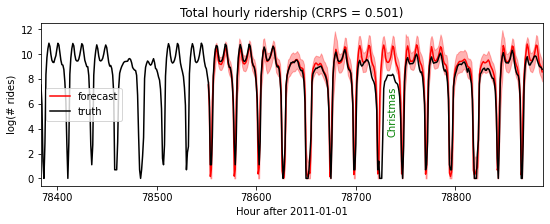

In [62]:
samples = forecaster(data[:T1], covariates, num_samples=100)
samples.clamp_(min=0)  # apply domain knowledge: the samples must be positive
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, data[T1:])

plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(torch.arange(T1 - 24 * 7, T2),
         data[T1 - 24 * 7: T2], 'k-', label='truth')
plt.title("Total hourly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Hour after 2011-01-01")
plt.xlim(T1 - 24 * 7, T2)
plt.text(78732, 3.5, "Christmas", rotation=90, color="green")
plt.legend(loc="best");

In [63]:
class Model3(ForecastingModel):
    def model(self, zero_data, covariates):
        duration = zero_data.size(-2)
        prediction = periodic_repeat(means, duration, dim=-1).unsqueeze(-1)

        # First sample the Gaussian-like parameters as in previous models.
        init_dist = dist.Normal(0, 10).expand([1]).to_event(1)
        timescale = pyro.sample("timescale", dist.LogNormal(math.log(24), 1))
        trans_matrix = torch.exp(-1 / timescale)[..., None, None]
        trans_scale = pyro.sample("trans_scale", dist.LogNormal(-0.5 * math.log(24), 1))
        obs_matrix = torch.tensor([[1.]])
        with pyro.plate("hour_of_week", 24 * 7, dim=-1):
            obs_scale = pyro.sample("obs_scale", dist.LogNormal(-2, 1))
        obs_scale = periodic_repeat(obs_scale, duration, dim=-1)

        # In addition to the Gaussian parameters, we will learn a global stability
        # parameter to determine tail weights, and an observation skew parameter.
        stability = pyro.sample("stability", dist.Uniform(1, 2).expand([1]).to_event(1))
        skew = pyro.sample("skew", dist.Uniform(-1, 1).expand([1]).to_event(1))

        # Next we construct stable distributions and a linear-stable HMM distribution.
        trans_dist = dist.Stable(stability, 0, trans_scale.unsqueeze(-1)).to_event(1)
        obs_dist = dist.Stable(stability, skew, obs_scale.unsqueeze(-1)).to_event(1)
        noise_dist = dist.LinearHMM(
            init_dist, trans_matrix, trans_dist, obs_matrix, obs_dist, duration=duration)

        # Finally we use a reparameterizer to enable inference.
        rep = LinearHMMReparam(None,                     # init_dist is already Gaussian.
                               SymmetricStableReparam(), # trans_dist is symmetric.
                               StableReparam())          # obs_dist is asymmetric.
        with poutine.reparam(config={"residual": rep}):
            self.predict(noise_dist, prediction)

In [64]:
pyro.set_rng_seed(1)
pyro.clear_param_store()
covariates = torch.zeros(len(data), 0)  # empty
forecaster = Forecaster(Model3(), data[:T1], covariates[:T1], learning_rate=0.1)
for name, value in forecaster.guide.median().items():
    if value.numel() == 1:
        print("{} = {:0.4g}".format(name, value.item()))

INFO 	 step    0 loss = 42.9186
INFO 	 step  100 loss = 0.243673
INFO 	 step  200 loss = 0.112298
INFO 	 step  300 loss = 0.0317115
INFO 	 step  400 loss = -0.0422226
INFO 	 step  500 loss = -0.0762992
INFO 	 step  600 loss = -0.108855
INFO 	 step  700 loss = -0.129329
INFO 	 step  800 loss = -0.143058
INFO 	 step  900 loss = -0.173671
INFO 	 step 1000 loss = -0.172415


timescale = 11.24
trans_scale = 0.04205
stability = 1.68
skew = -0.0001891


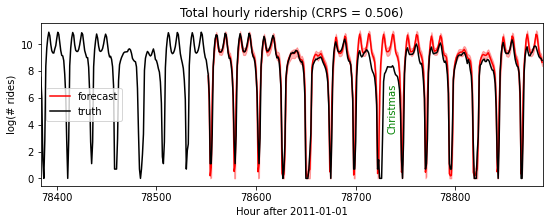

In [65]:
samples = forecaster(data[:T1], covariates, num_samples=100)
samples.clamp_(min=0)  # apply domain knowledge: the samples must be positive
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, data[T1:])

plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(torch.arange(T1 - 24 * 7, T2),
         data[T1 - 24 * 7: T2], 'k-', label='truth')
plt.title("Total hourly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Hour after 2011-01-01")
plt.xlim(T1 - 24 * 7, T2)
plt.text(78732, 3.5, "Christmas", rotation=90, color="green")
plt.legend(loc="best");

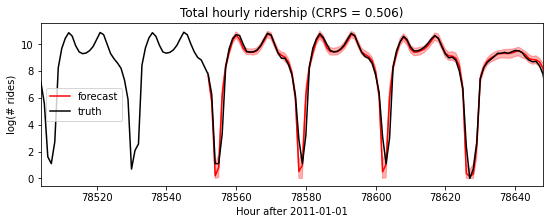

In [66]:
plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(torch.arange(T1 - 24 * 7, T2),
         data[T1 - 24 * 7: T2], 'k-', label='truth')
plt.title("Total hourly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Hour after 2011-01-01")
plt.xlim(T1 - 24 * 2, T1 + 24 * 4)
plt.legend(loc="best");